# MadMiner particle physics tutorial

# Appendix 6: Finite differences instead of morphing

Johann Brehmer, Felix Kling, Irina Espejo, Sinclert Pérez, and Kyle Cranmer 2018-2020

## Preparation

*Important*: You will need the MadMiner version on the `finite-differences` branch (https://github.com/diana-hep/madminer/tree/finite-differences). Get it with `git clone  -branch finite-differences https://github.com/diana-hep/madminer.git` followed by `pip install -e ./madminer`.

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [3]:
from madminer import MadMiner, LHEReader, combine_and_shuffle, plot_distributions, SampleAugmenter, sampling, ScoreEstimator

17:39 madminer             INFO    
17:39 madminer             INFO    |--------------------------------------------------------------------------|
17:39 madminer             INFO    |                                                                          |
17:39 madminer             INFO    | MadMiner v0.7.5                                                          |
17:39 madminer             INFO    |                                                                          |
17:39 madminer             INFO    | Johann Brehmer, Felix Kling, Irina Espejo, Sinclert Perez, Kyle Cranmer  |
17:39 madminer             INFO    |                                                                          |
17:39 madminer             INFO    |--------------------------------------------------------------------------|
17:39 madminer             INFO    


Please enter here the path to your MG5 root directory and to a Python2.7 executable that can be used to run MadGraph:

In [4]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_7_0'
python2 = '/Users/johannbrehmer/anaconda3/envs/python2/bin/python'

## 1. Input data

We consider Drell-Yan Z production with a decay into two muons (in this tutorial, the photon contribution to that process is turned off).

Have a look at the `cards` folder. You'll find text files ("cards") that specify the process simulation in typical MadGraph convention.

## 2. Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

In our case, we're just interested in a single parameter, the Z boson mass:

In [5]:
miner = MadMiner()
miner.add_parameter(lha_block='mass', lha_id=23, parameter_name='mz')


17:39 madminer.core.madmin INFO    Added parameter mz (LHA: mass 23, maximal power in squared ME: (2,), range: (0.0, 1.0))


## 3. Define benchmarks (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks" and define them with the `add_benchmark` function. Here we really just need one standard value, for which we use 91.2 GeV:

In [6]:
miner.add_benchmark({'mz':91.2}, 'mz_91_2')

17:39 madminer.core.madmin INFO    Added benchmark mz_91_2: mz = 91.20)


## 4. Finite difference setup

To construct the optimal observables, we will later need to compute the joint score. To compute the joint score, we need to compute the derivative of the event weights with respect to the parameter of interest (the Z mass). To compute this derivative, we use the method of finite differences, numerically computing the event weights both for `mz = 91.2 GeV` and for `mz = 91.2 GeV + ε` and using

```
d σ(mz) / d mz  ≈  [σ(91.2 GeV + ε) - σ(91.2 GeV)] / ε.
```

MadMiner supports this through the `finite_differences()` function, which adds an additional benchmark at `mz = 91.2 GeV + ε`.

In [7]:
miner.finite_differences(epsilon=0.1)

17:39 madminer.core.madmin INFO    Adding finite-differences benchmarks with epsilon = 0.1
17:39 madminer.core.madmin INFO    Added benchmark mz_91_2_plus_mz: mz = 91.30)


## 5. Save setup

The parameter space, benchmark points, and finite-difference setup are saved in a HDF5 file:

In [8]:
miner.save('data/setup_fd.h5')

17:39 madminer.core.madmin INFO    Saving setup (without morphing) to data/setup_fd.h5


They can now be loaded again with `miner.load(filename)`.

## 6. Generate events with MadGraph

To load this saved data (say if you want to repeat the following steps in a later session), you can just use this:

In [9]:
miner = MadMiner()
miner.load("data/setup_fd.h5")

17:39 madminer.core.madmin INFO    Found 1 parameters:
17:39 madminer.core.madmin INFO       mz (LHA: mass 23, maximal power in squared ME: (2,), range: (0.0, 1.0))
17:39 madminer.core.madmin INFO    Found 2 benchmarks:
17:39 madminer.core.madmin INFO       mz_91_2: mz = 91.20
17:39 madminer.core.madmin INFO       mz_91_2_plus_mz: mz = 91.30
17:39 madminer.core.madmin INFO    Did not find morphing setup.
17:39 madminer.core.madmin INFO    Did not find systematics setup.


In a next step, MadMiner calls MadGraph and creates the process folder. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and may be important for debugging.

The `sample_benchmark` keyword determines for which parameter setup we generate events.

One slight annoyance is that MadGraph only supports Python 2. The `run()` and `run_multiple()` commands have a keyword `initial_command` that let you load a virtual environment in which `python` maps to Python 2 (which is what we do below). Alternatively / additionally you can set `python2_override=True`, which calls `python2.7` instead of `python` to start MadGraph.

In [10]:
miner.run(
    sample_benchmark='mz_91_2',
    mg_directory=mg_dir,
    mg_process_directory='mg_processes/drell-yen',
    proc_card_file='cards/proc_card_dy.dat',
    param_card_template_file='cards/param_card_dy.dat',
    run_card_file='cards/run_card_dy.dat',
    log_directory='logs/drell-yan',
    python_executable=python2,
    only_prepare_script=True
)

17:39 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_dy.dat at mg_processes/drell-yen
17:39 madminer.utils.inter INFO    Calling MadGraph: /Users/johannbrehmer/anaconda3/envs/python2/bin/python /Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_7_0/bin/mg5_aMC /var/folders/wh/yq51b6390hj19dp2r7kwr53c0000gn/T/generate.mg5
17:39 madminer.core.madmin INFO    Run 0
17:39 madminer.core.madmin INFO      Sampling from benchmark: mz_91_2
17:39 madminer.core.madmin INFO      Original run card:       cards/run_card_dy.dat
17:39 madminer.core.madmin INFO      Original Pythia8 card:   None
17:39 madminer.core.madmin INFO      Original config card:    None
17:39 madminer.core.madmin INFO      Copied run card:         madminer/cards/run_card_0.dat
17:39 madminer.core.madmin INFO      Copied Pythia8 card:     None
17:39 madminer.core.madmin INFO      Copied config card:      None
17:39 madminer.core.madmin INFO      Param card:              madminer/cards/par

## 7. Generate events

Now follow the last printed line in the output of the last cell and run the run.sh script that actually generates the events. This will take a moment.

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there, do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

## 8. Prepare analysis of the LHE samples

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEReader` class, which has to be initialized with a MadMiner file:

In [5]:
lhe = LHEReader('data/setup_fd.h5')

After creating the `LHEReader` object, one can add a number of event samples (the output of running MadGraph in step 1) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [6]:
lhe.add_sample(
    lhe_filename='mg_processes/drell-yen/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='mz_91_2',
)


## 9. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define one observable, the invariant mass of the muon pair.

In [7]:
lhe.add_observable('mll', '(mu[0] + mu[1]).m', required=True,)


We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [14]:
lhe.add_cut('mll > 10.')


## 10. Parse events

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [8]:
lhe.analyse_samples()

17:39 madminer.lhe.lhe_rea INFO    Analysing LHE sample mg_processes/drell-yen/Events/run_01/unweighted_events.lhe.gz: Calculating 1 observables, requiring 0 selection cuts, using 0 efficiency factors, associated with no systematics


RuntimeError: Calling command gunzip -c mg_processes/drell-yen/Events/run_01/unweighted_events.lhe.gz > mg_processes/drell-yen/Events/run_01/unweighted_events.lhe returned exit code 1.

Std output:

b''Error output:

b'/bin/sh: mg_processes/drell-yen/Events/run_01/unweighted_events.lhe: No such file or directory\n'

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [ ]:
lhe.save('data/lhe_data_fd.h5')

## 11. Plot distributions

Let's see what our simulation produced:

In [ ]:
_ = plot_distributions(
    filename='data/lhe_data_fd.h5',
    parameter_points=['mz_91_2'],
    uncertainties='none',
    n_bins=50,
    n_cols=3,
    normalize=True,
)

That should look roughly like a Breit-Wigner :)

## 12. Extract training and test data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can fit a model.

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates the joint score that we will later use as targets in a regression problem.

In [9]:
sampler = SampleAugmenter('data/lhe_data_fd.h5')

17:39 madminer.analysis.da INFO    Loading data from data/lhe_data_fd.h5
17:39 madminer.analysis.da INFO    Found 1 parameters
17:39 madminer.analysis.da INFO      0: mz (mass / 23 / (2,) / (0.0, 1.0) / None)
17:39 madminer.analysis.da INFO    Did not find nuisance parameters
17:39 madminer.analysis.da INFO    Found 2 benchmarks, of which 2 physical
17:39 madminer.analysis.da INFO    Found 1 observables
17:39 madminer.analysis.da INFO    Found 10000 events
17:39 madminer.analysis.da INFO      10000 signal events sampled from benchmark mz_91_2
17:39 madminer.analysis.da INFO    Did not find morphing setup.
17:39 madminer.analysis.da INFO    Did not find nuisance morphing setup


In [16]:
x, _, t_xz, _ = sampler.sample_train_local(
    theta=sampling.benchmark('mz_91_2'),
    n_samples=100000,
    folder='./data/samples',
    filename='train_score',
    validation_split=0.0,
    test_split=0.2,
)

17:43 madminer.sampling.sa INFO    Extracting training sample for local score regression. Sampling and score evaluation according to mz_91_2
17:43 madminer.sampling.sa INFO    Starting sampling serially
17:43 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
17:43 madminer.sampling.sa INFO    Effective number of samples: mean 8000.0, with individual thetas ranging from 8000.0 to 8000.0


We can use the same data as in part 3a, so you only have to execute this if you haven't gone through tutorial 3a:

In [ ]:
_ = sampler.sample_test(
    theta=sampling.benchmark('mz_91_2'),
    n_samples=1000,
    folder='./data/samples',
    filename='test',
    validation_split=0.0,
    test_split=0.2,
)

## 13. Plot the training data

Let's have a look at what we just generated:

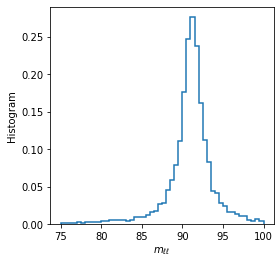

In [20]:
fig = plt.figure(figsize=(4,4))

plt.hist(x.flatten(), bins=50, range=(75,100), histtype="step", lw=1.5, density=True)

plt.xlabel(r"$m_{\ell\ell}$")
plt.ylabel(r"Histogram")

plt.show()

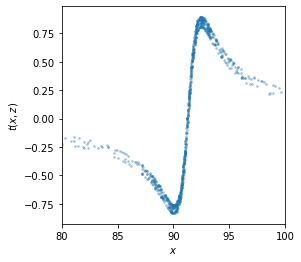

In [28]:
fig = plt.figure(figsize=(4,4))

plt.scatter(x.flatten()[::100], t_xz.flatten()[::100], alpha=0.3, s=3.)

plt.xlabel(r"$x$")
plt.ylabel(r"$t(x,z)$")

plt.xlim(80., 100.)

plt.show()

What's this? This is training data for the optimal observable we want to fit!